## ANLY590 Homework3
## Hongyang Zheng



In [59]:
# Libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
import itertools
import nltk
import string

from keras import backend as K
from skimage.transform import resize
from keras.datasets import fashion_mnist
from keras import regularizers
from keras import callbacks
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D, GlobalMaxPooling1D
from keras.layers import BatchNormalization, Lambda, Convolution1D, Convolution2D, ELU, concatenate, Conv1D
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping  

import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Problem 1 Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of Dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.

Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we’ve used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.
An example to guide your thinking can be found toward the bottom of this post https://blog.keras.io/building-autoencoders-in-keras.html. DO NOT JUST COPY THIS CODE AND TURN IT IN. BE CREATIVE, COME UP WITH YOUR OWN VARIATION.

After training your network, visualize some examples of input images and their decoded reconstruction.

In [3]:
# Load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
# Look at the shape
x_train.shape
y_train.shape

x_test.shape
y_test.shape

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

In [5]:
# Reshape the data 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Normalize the data between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Encode label y
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [7]:
# Build convolutional autoencoder
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid', use_bias=False)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

In [9]:
# See the autoencoder summary
autoencoder = Model(input_img, decoded)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        288       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 16)        4608      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 16)          2304      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 16)          0         
__________

In [10]:
# Fit the model
callbacks = [EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')]

autoencoder_history = autoencoder.fit(x_train, x_train,
                                      epochs=30,
                                      batch_size=128,
                                      validation_data=(x_test, x_test),
                                      callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 129s 2ms/step - loss: 0.2954 - val_loss: 0.2967
Epoch 2/30
60000/60000 [==============================] - 127s 2ms/step - loss: 0.2939 - val_loss: 0.2939
Epoch 3/30
60000/60000 [==============================] - 129s 2ms/step - loss: 0.2922 - val_loss: 0.2939
Epoch 4/30
60000/60000 [==============================] - 130s 2ms/step - loss: 0.2908 - val_loss: 0.2925
Epoch 5/30
60000/60000 [==============================] - 132s 2ms/step - loss: 0.2899 - val_loss: 0.2884
Epoch 6/30
60000/60000 [==============================] - 128s 2ms/step - loss: 0.2889 - val_loss: 0.2894
Epoch 7/30
60000/60000 [==============================] - 128s 2ms/step - loss: 0.2882 - val_loss: 0.2877
Epoch 8/30
60000/60000 [==============================] - 126s 2ms/step - loss: 0.2873 - val_loss: 0.2897
Epoch 9/30
60000/60000 [==============================] - 123s 2ms/step - loss: 0.2865 - val_loss: 0.2

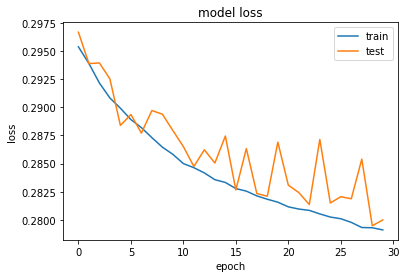

In [13]:
# Plot the train and test loss
plt.plot(autoencoder_history.history['loss'])
plt.plot(autoencoder_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show();

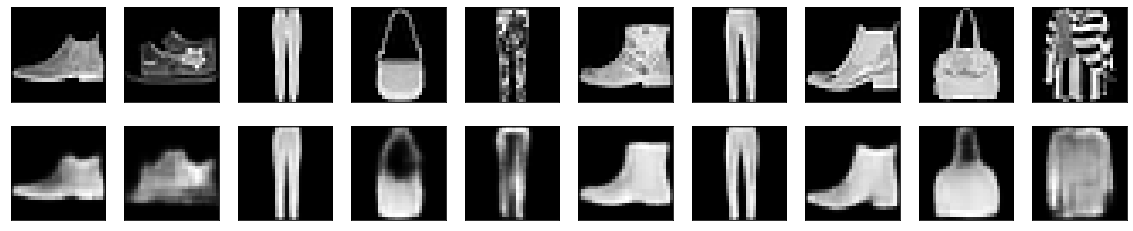

In [14]:
# Plot the original and reconstructed pictures
decoded_imgs = autoencoder.predict(x_test)

def display_picture(x_test, decoded_imgs, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[-i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[-i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

display_picture(x_test, decoded_imgs, 10)

### Problem 2 Image Classification
We’ll continue to use the Fashion MNIST dataset and build a deep convolutional network for classification.

### 2.1 Deep CNN
Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model’s performance on training set and test set.

#### The architecture of my CNN:
* kernel size: 3 x 3
* strides: 1 x 1
* padding: same
* network depth: 2
* pooling: max pooling with size 2

In [15]:
# Build CNN
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [16]:
# Take a look at the model summary
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)              0         
__________

In [18]:
# Fit the model
callbacks = [EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto')]

CNN_history = model.fit(x_train,
                             y_train,
                             batch_size=128,
                             epochs=20,
                             validation_data=(x_test, y_test),
                             callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 44s 738us/step - loss: 0.4630 - acc: 0.8312 - val_loss: 0.3683 - val_acc: 0.8662
Epoch 2/20
60000/60000 [==============================] - 46s 772us/step - loss: 0.3902 - acc: 0.8580 - val_loss: 0.3264 - val_acc: 0.8816
Epoch 3/20
60000/60000 [==============================] - 45s 753us/step - loss: 0.3478 - acc: 0.8736 - val_loss: 0.2971 - val_acc: 0.8930
Epoch 4/20
60000/60000 [==============================] - 41s 690us/step - loss: 0.3258 - acc: 0.8810 - val_loss: 0.2822 - val_acc: 0.8981
Epoch 5/20
60000/60000 [==============================] - 42s 706us/step - loss: 0.3061 - acc: 0.8876 - val_loss: 0.2791 - val_acc: 0.8988
Epoch 6/20
60000/60000 [==============================] - 42s 707us/step - loss: 0.2916 - acc: 0.8936 - val_loss: 0.2561 - val_acc: 0.9036
Epoch 7/20
60000/60000 [==============================] - 43s 711us/step - loss: 0.2776 - acc: 0.8976 - val_loss: 0.

In [19]:
# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=1)
print("The test score: {acc}".format(acc = score))

10000/10000 [==============================] - 2s 155us/step
The test score: [0.2130239243209362, 0.9221]


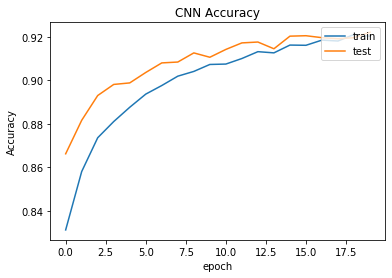

In [23]:
# Plot the performance
plt.plot(CNN_history.history['acc'])
plt.plot(CNN_history.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show();

### 2.2 Transfer Learning
Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model’s performance on training set and test set.

In [29]:
# Reload the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Change the data into a different size
x_train = x_train.reshape(x_train.shape[0], 784).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 784).astype('float32')
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test]*3)
x_train = x_train.reshape(x_train.shape[0],28,28,3).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,3).astype('float32')
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((50, 50))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((50, 50))) for im in x_test])

# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

# Encode the y label
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [30]:
# Look at the shape
x_train.shape
x_test.shape

(60000, 50, 50, 3)

(10000, 50, 50, 3)

In [31]:
# Use VGG16
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(50,50,3))

# Add dense layer
transfer_model = Sequential()
transfer_model.add(conv_base)
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation="relu"))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(10, activation="softmax"))   
conv_base.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
# Take a look of the summary
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
# Fit the model
transfer_model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["acc"])

VGG16_history = transfer_model.fit(x_train, y_train,
          epochs=10,
          batch_size=128,
          validation_split = 0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 1031s 25ms/step - loss: 0.7187 - acc: 0.7530 - val_loss: 0.4604 - val_acc: 0.8344
Epoch 2/10
42000/42000 [==============================] - 1010s 24ms/step - loss: 0.4763 - acc: 0.8294 - val_loss: 0.4060 - val_acc: 0.8568
Epoch 3/10
42000/42000 [==============================] - 1034s 25ms/step - loss: 0.4259 - acc: 0.8468 - val_loss: 0.3845 - val_acc: 0.8595
Epoch 4/10
42000/42000 [==============================] - 1046s 25ms/step - loss: 0.4046 - acc: 0.8532 - val_loss: 0.3696 - val_acc: 0.8671
Epoch 5/10
42000/42000 [==============================] - 1015s 24ms/step - loss: 0.3860 - acc: 0.8615 - val_loss: 0.3632 - val_acc: 0.8698
Epoch 6/10
42000/42000 [==============================] - 998s 24ms/step - loss: 0.3735 - acc: 0.8633 - val_loss: 0.3531 - val_acc: 0.8717
Epoch 7/10
42000/42000 [==============================] - 998s 24ms/step - loss: 0.3624 - acc: 0.8672 - val_los

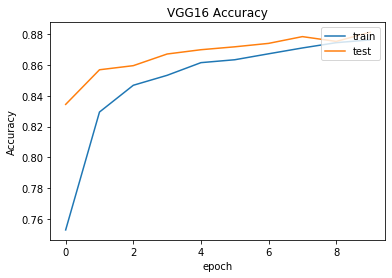

In [37]:
# Plot the performance
plt.plot(VGG16_history.history['acc'])
plt.plot(VGG16_history.history['val_acc'])
plt.title('VGG16 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show();

### Problem Text Classification

While images contain local spatial correlations and structure, many other datasets contain temporal correlations. Examples include time series and discrete sequences such as text. In this problem, we will tackle the task of text classification in the context of natural language.

Background. In this problem, we will build models that read short text segments (tweets) and identify if one or more specific topics are being discussed. The dataset consists of tweets along with labels for which topics were being referenced in the tweet. Examples of the topics include ”storms”, ”rain”, ”hurricane”, ”snow” and so on. Unlike previous classification problems we have encountered, in this dataset, there is not just a single right answer. The labels here are derived from multiple annotators decided how to label each tweet, so a single tweet can be about more than one topic. The label is the fraction of annotations for a given topic, and each row should sum to 1.

What Loss function should you use here? Categorical CrossEntropy might work, but with some modification since we don’t have ”hard” labels over the categories. Another option might be sigmoid: for each output category, use a sigmoid to collapse the output to between 0 and 1, but each category output can be roughly independent of the others. In the problems below, feel free to try both.

### 3.1 RNN
Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).


In [37]:
# Read data
text_data = pd.read_csv('tweets_with_labels.csv', sep='\t')

# Look at the data 
text_data.head(20)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,1.000,0.0,0.0,0.000,0.0,0.000
1,2,RT: @mention: I love rainy days.,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,1.000,0.0,0.0,0.000,0.0,0.000
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.000,0.000,0.000,0.000,0.0,1.000,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.000,0.000,0.000,0.000,0.0,0.604,0.0,0.196,0.000,0.0,0.0,0.201,0.0,0.000
4,9,@mention good morning sunshine,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,1.000,0.0,0.000
5,10,Rather be storm chasing.,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,1.0,0.000,0.0,0.000
6,11,#WEATHER: 1:54 pm : 61.0F. Feels 60F. 29.98% ...,0.0,0.203,0.176,0.000,0.376,0.0,0.421,0.0,0.176,0.000,0.0,0.0,0.000,0.0,0.579
7,13,Father. Son. Holy ghost. Amen... hope I come o...,0.0,0.000,0.000,1.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000
8,14,Mild Monday best weather day of the week in Ok...,0.0,0.000,0.000,0.194,0.000,0.0,0.605,0.0,0.200,0.000,0.0,0.0,0.000,0.0,0.000
9,15,"With the snow forecast for Tahoe this weekend,...",0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,1.0,0.0,0.000,0.0,0.000


In [38]:
# Preprocess and clean the data
# Take from my ANLY580 project
def process_tweets(tweets):
    
    tweets_clean = []

    for tweet in tweets:

        # Take tokens
        tokens = nltk.casual_tokenize(tweet)

        # Remove URL
        tokens = [term for term in tokens if not term.startswith('{') ]

        # Remove profiles
        tokens1 = [term for term in tokens if not term.startswith('@')]

        # Remove punctuation
        punctuation = list(string.punctuation)
        tokens2 = [term for term in tokens1 if term not in punctuation]

        # Remove hashtags
        tokens3 = [term for term in tokens2 if not term.startswith('#')]
        
        # Remove empty sentence
        if tokens3 != []: 
            sentence3 = ' '.join(tokens3) 
        else:
            sentence3 = 'no words left'
        tweets_clean.append(sentence3)
    
    return tweets_clean

text_data['tweet_clean'] = process_tweets(text_data['tweet'])

In [39]:
# Look at the new data
text_data.head(20)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,tweet_clean
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,1.000,0.0,0.0,0.000,0.0,0.000,Jazz for a Rainy Afternoon link
1,2,RT: @mention: I love rainy days.,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,1.000,0.0,0.0,0.000,0.0,0.000,RT I love rainy days
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.000,0.000,0.000,0.000,0.0,1.000,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000,Good Morning Chicago Time to kick the Windy Ci...
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.000,0.000,0.000,0.000,0.0,0.604,0.0,0.196,0.000,0.0,0.0,0.201,0.0,0.000,Preach lol :) RT this type of weather all the ...
4,9,@mention good morning sunshine,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,1.000,0.0,0.000,good morning sunshine
5,10,Rather be storm chasing.,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,1.0,0.000,0.0,0.000,Rather be storm chasing
6,11,#WEATHER: 1:54 pm : 61.0F. Feels 60F. 29.98% ...,0.0,0.203,0.176,0.000,0.376,0.0,0.421,0.0,0.176,0.000,0.0,0.0,0.000,0.0,0.579,1:54 pm 61.0 F Feels 60F 29.98 Humidity 6.9 MP...
7,13,Father. Son. Holy ghost. Amen... hope I come o...,0.0,0.000,0.000,1.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000,Father Son Holy ghost Amen ... hope I come out...
8,14,Mild Monday best weather day of the week in Ok...,0.0,0.000,0.000,0.194,0.000,0.0,0.605,0.0,0.200,0.000,0.0,0.0,0.000,0.0,0.000,Mild Monday best weather day of the week in Ok...
9,15,"With the snow forecast for Tahoe this weekend,...",0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,1.0,0.0,0.000,0.0,0.000,With the snow forecast for Tahoe this weekend ...


In [40]:
# Get the clean non-empty data
text_clean = text_data[text_data['tweet_clean'] != 'no words left']

In [41]:
# Take text and label
text = text_clean['tweet_clean']
label = text_clean.iloc[:,2:-1].values

In [42]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=100)

tokenizer = Tokenizer(num_words = 500)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train) 
test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_2 = pad_sequences(train_sequences, maxlen = 50)
x_test_2 = pad_sequences(test_sequences, maxlen = 50)

In [43]:
# Split train into train and validation
train_x = x_train_2[:50000]
val_x = x_train_2[50000:]

train_y = y_train[:50000]
val_y = y_train[50000:]

#### Method 1

In [45]:
# Apply LSTM with softmax
model = Sequential()
model.add(Embedding(500, 64))
model.add(LSTM(32))
model.add(Dense(15, activation = 'softmax'))

In [47]:
# Fit the model using categorical_crossentropy as loss
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
RNN_history = model.fit(train_x, train_y, 
                        epochs = 20, 
                        validation_data = (val_x, val_y), 
                        batch_size = 64, 
                        verbose = 1)

Train on 50000 samples, validate on 12320 samples
Epoch 1/20
50000/50000 [==============================] - 97s 2ms/step - loss: 1.6965 - acc: 0.6764 - val_loss: 1.5489 - val_acc: 0.6976
Epoch 2/20
50000/50000 [==============================] - 94s 2ms/step - loss: 1.3069 - acc: 0.7917 - val_loss: 1.3072 - val_acc: 0.7917
Epoch 3/20
50000/50000 [==============================] - 94s 2ms/step - loss: 1.2549 - acc: 0.7978 - val_loss: 1.2740 - val_acc: 0.7943
Epoch 4/20
50000/50000 [==============================] - 97s 2ms/step - loss: 1.2302 - acc: 0.8025 - val_loss: 1.2591 - val_acc: 0.7969
Epoch 5/20
50000/50000 [==============================] - 96s 2ms/step - loss: 1.2146 - acc: 0.8040 - val_loss: 1.2540 - val_acc: 0.8020
Epoch 6/20
50000/50000 [==============================] - 96s 2ms/step - loss: 1.2036 - acc: 0.8070 - val_loss: 1.2414 - val_acc: 0.8042
Epoch 7/20
50000/50000 [==============================] - 94s 2ms/step - loss: 1.1954 - acc: 0.8084 - val_loss: 1.2366 - val_acc

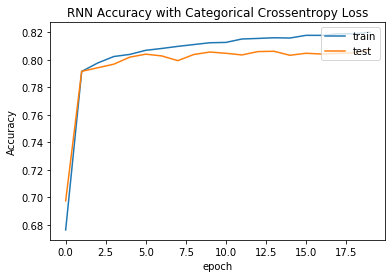

In [50]:
# Plot the performance
plt.plot(RNN_history.history['acc'])
plt.plot(RNN_history.history['val_acc'])
plt.title('RNN Accuracy with Categorical Crossentropy Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show();

#### Method 2

In [52]:
# Apply LSTM with sigmoid
model2 = Sequential()
model2.add(Embedding(500, 64))
model2.add(LSTM(64))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(15, activation = 'sigmoid'))

In [54]:
# Fit the model using binary_crossentropy as loss
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
RNN2_history = model2.fit(train_x, train_y, 
                        epochs = 15, 
                        validation_data = (val_x, val_y), 
                        batch_size = 128, 
                        verbose = 1)

Train on 50000 samples, validate on 12320 samples
Epoch 1/15
50000/50000 [==============================] - 74s 1ms/step - loss: 0.2464 - acc: 0.8713 - val_loss: 0.1684 - val_acc: 0.8908
Epoch 2/15
50000/50000 [==============================] - 69s 1ms/step - loss: 0.1433 - acc: 0.9020 - val_loss: 0.1250 - val_acc: 0.9058
Epoch 3/15
50000/50000 [==============================] - 70s 1ms/step - loss: 0.1229 - acc: 0.9085 - val_loss: 0.1170 - val_acc: 0.9079
Epoch 4/15
50000/50000 [==============================] - 70s 1ms/step - loss: 0.1167 - acc: 0.9100 - val_loss: 0.1135 - val_acc: 0.9090
Epoch 5/15
50000/50000 [==============================] - 68s 1ms/step - loss: 0.1131 - acc: 0.9108 - val_loss: 0.1115 - val_acc: 0.9095
Epoch 6/15
50000/50000 [==============================] - 67s 1ms/step - loss: 0.1109 - acc: 0.9111 - val_loss: 0.1102 - val_acc: 0.9095
Epoch 7/15
50000/50000 [==============================] - 66s 1ms/step - loss: 0.1095 - acc: 0.9114 - val_loss: 0.1094 - val_acc

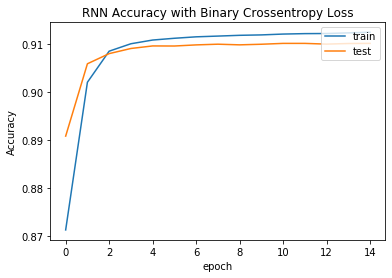

In [55]:
# Plot the performance
plt.plot(RNN2_history.history['acc'])
plt.plot(RNN2_history.history['val_acc'])
plt.title('RNN Accuracy with Binary Crossentropy Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show();

From above comparison we can see that using sigmoid activation function with binary crossentropy loss has a higher accuracy than using softmax activation function with categorical crossentropy loss. So, in the next CNN part, I will use method2 to fit the model.

### 3.2 CNN
Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings). You might gain some insight and inspiration from these text classification approaches:

• http://www.aclweb.org/anthology/D14-1181

• https://arxiv.org/abs/1702.08568

In [60]:
# Build CNN model
model3 = Sequential()
model3.add(Embedding(500, 64))
model3.add(Conv1D(64, kernel_size = 3, padding='valid', activation='relu', strides=1))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.3))

model3.add(Dense(64, activation='relu'))
model3.add(Dense(15, activation='sigmoid'))

In [61]:
# Fit the model
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
CNN2_history = model3.fit(
                        train_x, train_y, 
                        epochs = 15, 
                        validation_data = (val_x, val_y), 
                        batch_size = 128, 
                        verbose = 1)

Train on 50000 samples, validate on 12320 samples
Epoch 1/15
50000/50000 [==============================] - 12s 248us/step - loss: 0.2097 - acc: 0.8860 - val_loss: 0.1211 - val_acc: 0.9077
Epoch 2/15
50000/50000 [==============================] - 10s 203us/step - loss: 0.1225 - acc: 0.9086 - val_loss: 0.1123 - val_acc: 0.9096
Epoch 3/15
50000/50000 [==============================] - 10s 209us/step - loss: 0.1161 - acc: 0.9100 - val_loss: 0.1100 - val_acc: 0.9100
Epoch 4/15
50000/50000 [==============================] - 11s 217us/step - loss: 0.1131 - acc: 0.9106 - val_loss: 0.1087 - val_acc: 0.9100
Epoch 5/15
50000/50000 [==============================] - 11s 216us/step - loss: 0.1112 - acc: 0.9108 - val_loss: 0.1080 - val_acc: 0.9101
Epoch 6/15
50000/50000 [==============================] - 11s 211us/step - loss: 0.1095 - acc: 0.9111 - val_loss: 0.1074 - val_acc: 0.9101
Epoch 7/15
50000/50000 [==============================] - 11s 219us/step - loss: 0.1084 - acc: 0.9112 - val_loss: 0.

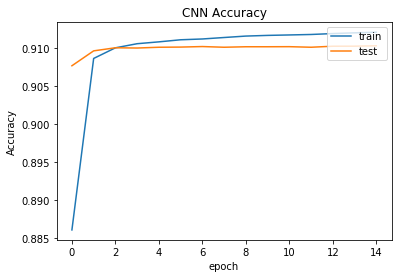

In [62]:
# Plot the performance
plt.plot(CNN2_history.history['acc'])
plt.plot(CNN2_history.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show();

### 3.3 Compare 
Be sure to directly compare your two methods with an ROC curve or similar validation method. Don’t forget to create a train-test split.

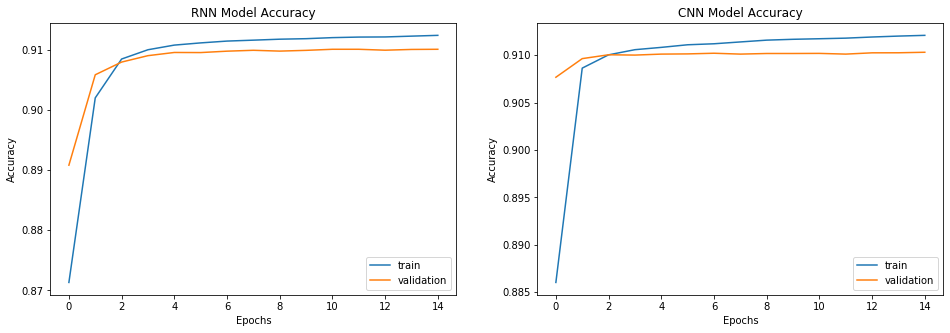

In [68]:
# Compare the results
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(RNN2_history.history['acc'])
plt.plot(RNN2_history.history['val_acc'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(CNN2_history.history['acc'])
plt.plot(CNN2_history.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show();

In [70]:
# Calculate test loss and accuracy
RNN_loss, RNN_acc = model2.evaluate(x_test_2, y_test)
print('The loss of test data is:', RNN_loss)
print('The accuray of test data is: %.2f%%' % (RNN_acc*100))

CNN_loss, CNN_acc = model3.evaluate(x_test_2, y_test)
print('The loss of test data is:', CNN_loss)
print('The accuray of test data is: %.2f%%' % (CNN_acc*100))

15580/15580 [==============================] - 12s 786us/step
The loss of test data is: 0.10421161538178869
The accuray of test data is: 91.16%
15580/15580 [==============================] - 1s 84us/step
The loss of test data is: 0.10397701924320057
The accuray of test data is: 91.16%


From these graphs, we can see that the performance of RNN and CNN are very similar, with the same test accuracy and training pattern.